In [ ]:
### For Continous action space, we need the model to predict a continous distribution for each action 
### For example, if for a 2D environment, an agent can move either along x-axis or along y-axis. So, there 
### are two components of the action, we need to predict two continous distributions.

### In the case of discrete action space, we use categorical distributions, i.e, we have n actions in the entire 
### action space, so we can obtain a value of the probability for the entire action space, and they are differentiable.

### In case of continious action space, we predict a gaussian distribution, or a continous, cumulative density function.
### In case of CDFs, there is no existence of any particular set of actions. So, for CDF, the probability of an action
### in the CDF, is the value of integration, from the beginning of the distribution to the point of the action.
### The value is the probability of the action. But we can not differentitate the obtained value, and also the distributions
### So, it is not possible to obtain the gradients.

### Here, we use a reparameterization trick. 

### REPARMETERIZATION TRICK

### If there is a distribution P(theta), and we can only sample variable x from the distribution, we can find the mean and 
### standard devation of the distribution, and shift a random noise according to the mean and standard deviation to recreate 
### the arbitrary distribution.

### We assume the probability distribution P(theta) can be given as N(mu,sigma), where N is a normal distribution. So, we create 
### a standard normal distribution N(0,1) and sample from it, then multiply the sample by sigma (scaling) and add with mu (translation)
### to convert the sample from N(0,1) to N(mu,sigma). So, we can easily find the probabilty, as we sample from the known distribution.
### So, x = mu + sigma*Epsilon, where epsilon is sampled from N(0,1) and x from the probability distriibution.

### As we use the parameters of the distribution, this is called reparameterization trick. 

### Now, as for the samples, we have the mu and sigma, we can find the gradients on the same, and they are differentiable.


In [1]:
import matplotlib.pyplot as plt
import cv2

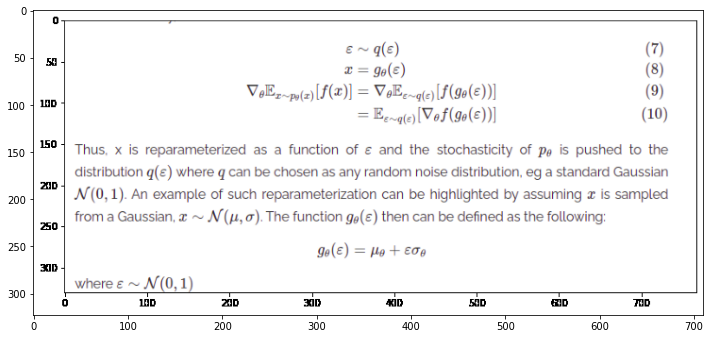

In [2]:
img=cv2.imread("Reparameterization.png")
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

In [ ]:
### ANALYTIC

In [6]:
import tensorflow_probability as tfp
def P(x,mu,sigma):

  a=np.divide(1.,(sigma*np.math.sqrt(2.*np.pi)))
  b=np.exp(-0.5*np.square((x-mu)/sigma))
  return a*b

#### The above equation is the formula for obtaining the probability of a value from a normal distribution
#### with mean mu and standard deviation sigma. It is simply obtaining the N(mu,sigma)

def sample(mu,sigma):

  val=tfp.distributions.Normal(0,1).sample()
  return mu+sigma*val

In [7]:
mu= 0.5
sigma=2

In [8]:
val=sample(0.5,2).numpy()

In [9]:
val

-0.525615

In [11]:
import numpy as np

In [12]:
P(val,mu,sigma)

0.17489465218057557

In [13]:
#### The same above thing can be achieved by: tfp.distributions.Normal(mu,sigma)

### as it does the same reparameterization trick under the hood

In [14]:
dist=tfp.distributions.Normal(mu,sigma)

In [15]:
val=dist.sample()

In [16]:
val.numpy()

3.416626

In [17]:
dist.prob(val).numpy()

0.06887761

In [ ]:
### So, we can use this function instead.

### We need our model to predict the mean mu and standard deviation sigma. 

### Now, mean gives the action, which is dependent on the state, while sigma gives the entropy for exploration.

### To prevent the exploration from being too high we clip the value of exploration in between certain values.

### So, instead of predicting the sigma values directly, we make our model predict log value of sigma or standard
### deviation and take exponention of the value after clipping, to get the original sigma for the distribution.

### So, if we have two continous actions, we need two sets of two nodes in the last layer, for predicting the means 
### and standard devations of the two continous action,

### During the testing, we pass only the mean as the action. 

### Render

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

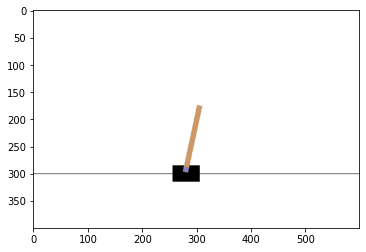

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

In [ ]:
!pip install roboschool==1.0.48 gym==0.15.4

     |████████████████████████████████| 44.9MB 148kB/s 
     |████████████████████████████████| 1.6MB 33.2MB/s 
     |████████████████████████████████| 1.0MB 26.0MB/s 
  Created wheel for gym: filename=gym-0.15.4-cp37-none-any.whl size=1648486 sha256=9a1fcf76db1c3e8160371e1647f04ae55583711a45440da99c8ae82a0bbdca51
  Stored in directory: /root/.cache/pip/wheels/e9/26/9b/8a1a6599a91077a938ac4348cc3d3ac84bfab0dbfddeb4c6e7
Successfully built gym
ERROR: tensorflow-probability 0.12.1 has requirement cloudpickle>=1.3, but you'll have cloudpickle 1.2.2 which is incompatible.
  Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
### The A2C algorithms are very less sample efficient, and hence is unsuitable for solving continous action space problems.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
import gym
import roboschool

In [ ]:
### The pi_old is the poicy for the n-1 th iteration policy, when we calculate for n th iteration.
### The constraint is only applied for a particuar iteration for the batch updates.

In [ ]:
class PPO_continous_action:

  def __init__(self,env):

    self.env=env
    self.state_dimension=env.observation_space.shape   ###PPO_continous_action_space Input state dimension
    self.no_of_action=env.action_space.shape[0]              ### No of actions
    self.Actor=None      ### the learner
    self.Critic=None     ### Critic
    self.opt=tf.keras.optimizers.Adam(0.0003)
    self.steps_in_epi=512    ### Fixed number of steps in a episode
    self.iterations=5000         ### Number of epochs
    self.m=8                 ### Number of samples in a epoch.
    #self.log_std=tf.Variable(tf.zeros((1,self.no_of_action)))
    self.max_clip_value=2
    self.min_clip_value=-20
    self.epochs=10

  
  def get_actor(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the probability distribution of the actions.

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer_mu=tf.keras.layers.Dense(self.no_of_action,activation=None)(layer_3)
    output_layer_log_sigma=tf.keras.layers.Dense(self.no_of_action,activation=None)(layer_3)

    ### Predicts the peobability of all the actions on the state s, so the number of nodes in
    ### the final layer of model is equal to the number of actions 
    ### and we generate the mean action of the state so, we use a relu instead of softmax in case of discrete actions
    
    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer_mu,output_layer_log_sigma])
    
    return model
  
  def get_critic(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the estimate value function V(s)

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(1)(layer_3)  ### Predicts the Value function for that state.

    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    return model
  
  
  def action(self,s):
    
    s=s.reshape(1,-1)
    mu,log_sigma=self.Actor(s)
    action_prob=tfp.distributions.Normal(mu,tf.math.exp(tf.clip_by_value(log_sigma,self.min_clip_value,self.max_clip_value)))
    action= action_prob.sample()
    ### sampling an action from the obtained probability distributions for all the action
    return action.numpy()[0]  ### Action returned as 1D tensor-> converting to scalar

  def prob(self,s,a):

    mu,log_sigma=self.Actor(s)
    ### again to be used in batch
    action_prob=tfp.distributions.Normal(mu,tf.math.exp(tf.clip_by_value(log_sigma,self.min_clip_value,self.max_clip_value)))
    ### takes in the states and the actions and returns the corresponding log probability 
    ### of the occurence of the taken action a on the state s
    ### log(P[a|s : w]) is obtained.
    return action_prob.log_prob(a)
  
  def get_value(self,state):
    state=state.reshape(1,-1)
    value=self.Critic(state).numpy()[0]
    return value

  def get_test_action(self,s):
    s=s.reshape(1,-1)
    mean_action,_=self.Actor(s)
    return mean_action.numpy()[0]

  def actor_loss(self,log_old_probs,S,A,Adv,epsilon=0.2):
    
    log_new_probs=self.prob(S,A)  
    importance_ratio = tf.math.exp(tf.math.subtract(log_new_probs,log_old_probs))
    surr_1=tf.multiply(importance_ratio,Adv)
    surr_2=tf.multiply(tf.clip_by_value(importance_ratio,1-epsilon,1+epsilon),Adv)
    L_clip=-1*tf.reduce_mean(tf.reduce_min([surr_1,surr_2],axis=0))
    
    return L_clip

  def critic_loss(self,S,ret):
    L_vf= 0.5*tf.reduce_mean(tf.math.squared_difference(ret,self.Critic(S)))
    return L_vf
  
  def entropy(self,S):
    mu,log_sigma=self.Actor(S)
    dist=tfp.distributions.Normal(mu,tf.math.exp(tf.clip_by_value(log_sigma,self.min_clip_value,self.max_clip_value)))
    L_S=tf.reduce_mean(dist.entropy())
    return L_S
    ### Entropy induces exploration.
  
  def total_loss(self,old_probs,S,A,rets,Adv,c1=0.5,c2=0.001):
    act_loss=self.actor_loss(old_probs,S,A,Adv)
    crit_loss=self.critic_loss(S,rets)
    entropy_loss=self.entropy(S)

    total_loss=act_loss+c1*crit_loss-c2*entropy_loss
    return total_loss
  
  def train_on_batch(self,probs,s,a,adv,r):
    with tf.GradientTape() as t:
        loss=self.total_loss(probs,s,a,r,adv)
      ### Calculating loss
    grads=t.gradient(loss,self.Actor.trainable_variables+self.Critic.trainable_variables)

    self.opt.apply_gradients(zip(grads,self.Actor.trainable_variables+self.Critic.trainable_variables))
    #### Applying gradients.
    return 0
  
  def get_episodes(self):
    ### To sample raw walks in the environment
    states=[]
    actions=[]
    rewards=[]
    values=[]
    next_values=[]
    not_done=[]
    old_probs=[]
    

    done=False
    curr_state=self.env.reset()
    for _ in range(self.steps_in_epi):
      ### Recording fixed number of steps.
      action=self.action(curr_state)
      next_state,reward,done,_=self.env.step(action)
      #print(curr_state)
      value=self.get_value(curr_state)
      #print(f"Value {value}")
      next_value=self.get_value(next_state)
      prob=self.prob(curr_state.reshape(1,-1),action)
      #print(f"Prob {prob}")
      ### Obtaining next step.

      states.append(curr_state)
      actions.append(action)
      rewards.append([reward])
      values.append(value)
      next_values.append(next_value)
      not_done.append([not done])
      old_probs.append(prob[0])
      
      ### logging the essential required values for loss estimation
      if done:
        curr_state=self.env.reset()  ### If done, every value is reset.
        done=False
      else: 
        curr_state=next_state ### Updating.

    return np.array(states),np.array(actions),np.array(rewards),np.array(values),np.array(next_values),np.array(not_done),np.array(old_probs)  ### All logs returned

  def get_gae(self,next_values,values,rewards,not_dones,gamma=0.99,lam=0.95):
    
    gae=0
    returns=[]
    ### Calculating GAE according to formulation.
    for step in reversed(range(len(rewards))):
      TD_error_delta = rewards[step] + gamma * next_values[step] * not_dones[step] - values[step]
      gae = TD_error_delta + gamma * lam * not_dones[step] * gae
      ret = gae + values[step]
      returns.insert(0,ret)
    
    return np.array(returns)

  def get_experience(self,m):
    #### Getting the experience for all m samplings.
    states=[]
    actions=[]
    returns=[]
    values=[]
    old_probs=[]

    for i in range(m):
      s,a,r,v,nv,nd,op=self.get_episodes()
      ret=self.get_gae(nv,v,r,nd)

      ### For each episode in number of samples, collecting experience
      old_probs.extend(op)
      states.extend(s)
      actions.extend(a)
      returns.extend(ret)
      values.extend(v)
   
    return np.array(states),np.array(actions),np.array(returns),np.array(values),np.array(old_probs)

  def test_play(self):
    ### Testing results for current weights.
    overall=0
    for _ in range(5):
      curr_state=self.env.reset()
      total_reward=0
      done=False
      while not done:
        a=self.action(curr_state.reshape(1,-1))
        next_state,reward,done,_=self.env.step(a)
        total_reward+=reward
        curr_state=next_state
      overall+=total_reward
    return overall/5
  
  def train(self,batch_size=128):
    ### Training
    self.Actor=self.get_actor()
    self.Critic=self.get_critic()

    for i in range(self.iterations):
      ### For each epoch
      s,a,r,v,op=self.get_experience(self.m)
      r=r.astype('float32')
      adv=r-v
      adv=adv.astype('float32')
      adv=(adv-adv.mean())/(adv.std())
      total_no_of_samples=len(s)


      dataset=tf.data.Dataset.from_tensor_slices((op,s,a,adv,r)).shuffle(total_no_of_samples).repeat(self.epochs).batch(batch_size,drop_remainder=True)         

      for (prob_sample,s_sample,a_sample,adv_sample,r_sample) in dataset:
        self.train_on_batch(prob_sample,s_sample,a_sample,adv_sample,r_sample)
      
    
      if i%10==0:
        score=self.test_play()
        print(f"On Iteration {i} scores: {score}")

  


In [ ]:
env = gym.make('RoboschoolInvertedPendulum-v1')

In [ ]:
agent=PPO_continous_action(env)

In [ ]:
agent.train()

On Iteration 0 scores: 36.6
On Iteration 10 scores: 1000.0


In [ ]:
env = gym.make('RoboschoolInvertedDoublePendulum-v1')

In [ ]:
agent=PPO_continous_action(env)

In [ ]:
agent.train()

On Iteration 0 scores: 323.5257588013472
On Iteration 10 scores: 1367.4522057670035
On Iteration 20 scores: 6345.646948470329
On Iteration 30 scores: 6207.415700167069
